# Appel à une API Hugging Face pour la Segmentation d'Images


Nous allons respecter le guide fourni :
1.  **Configuration Initiale**
2.  **Comprendre l'API**
3.  **Fonctions Utilitaires** (Décodage Base64)
4.  **Segmentation d'une seule image**
5.  **Segmentation Batch (50 images)**
6.  **Affichage**
7.  **Rapport et Coûts** (Demandés dans le brief projet)


API_URL = "https://router.huggingface.co/hf-inference/models/sayeed99/segformer_b3_clothes"  
headers = {
    "Authorization": f"Bearer {api_token}"
    # Le "Content-Type" sera ajouté dynamiquement lors de l'envoi de l'image
}


In [ ]:
# 1. Configuration Initiale et Importations
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import base64
import io
from dotenv import load_dotenv

# Variables de Configuration
image_dir = "top_influenceurs_2024/IMG"
mask_dir = "top_influenceurs_2024/Mask"
results_dir = "results_segmentation"

# Chargement du token
load_dotenv()
api_token = os.getenv("HF_TOKEN")

# Création des dossiers si nécessaire
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if not api_token:
    print("ATTENTION : Token introuvable dans .env")
    api_token = "VOTRE_TOKEN_ICI" 
else:
    print("Token chargé avec succès.")

Token chargé avec succès.


In [ ]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="auto",
    api_key=os.environ["HF_TOKEN"],
)

output = client.image_segmentation("top_influenceurs_2024/IMG\image_0.png", model="sayeed99/segformer_b3_clothes")

In [ ]:
output

[ImageSegmentationOutputElement(label='Background', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD1A4AD0>, score=1),
 ImageSegmentationOutputElement(label='Hair', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD1AE0D0>, score=1),
 ImageSegmentationOutputElement(label='Upper-clothes', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD1AE210>, score=1),
 ImageSegmentationOutputElement(label='Pants', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD14DA70>, score=1),
 ImageSegmentationOutputElement(label='Left-shoe', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD14DF30>, score=1),
 ImageSegmentationOutputElement(label='Right-shoe', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD14DE00>, score=1),
 ImageSegmentationOutputElement(label='Face', mask=<PIL.PngImagePlugin.PngImageFile image mode=L size=400x600 at 0x154CD14E060>, score=1),


In [ ]:
# 2. Comprendre l'API d'Inférence Hugging Face

# Modèle utilisé : sayeed99/segformer_b3_clothes
API_URL = "https://router.huggingface.co/hf-inference/models/sayeed99/segformer_b3_clothes"
headers = {
    "Authorization": f"Bearer {api_token}"
}

# Lister les chemins des images à traiter
image_paths = []
if os.path.exists(image_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    image_paths = [os.path.join(image_dir, f) for f in image_files]
else:
    print(f"Le dossier {image_dir} n'existe pas.")

if not image_paths:
    print(f"Aucune image trouvée dans '{image_dir}'.")
else:
    print(f"{len(image_paths)} image(s) trouvée(s) à traiter.")

50 image(s) trouvée(s) à traiter.


In [ ]:
# 3. Fonctions Utilitaires pour le Traitement des Masques

CLASS_MAPPING = {
    "Background": 0, "Hat": 1, "Hair": 2, "Sunglasses": 3, "Upper-clothes": 4, "Skirt": 5,
    "Pants": 6, "Dress": 7, "Belt": 8, "Left-shoe": 9, "Right-shoe": 10, "Face": 11,
    "Left-leg": 12, "Right-leg": 13, "Left-arm": 14, "Right-arm": 15, "Bag": 16, "Scarf": 17
}

def get_image_dimensions(img_path):
    original_image = Image.open(img_path)
    return original_image.size

def decode_base64_mask(base64_string, width, height):
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def create_masks(results, width, height):
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    
    # D'abord les objets
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0: continue
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id
        
    # Ensuite le background
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_base64_mask(result['mask'], width, height)
            combined_mask[mask_array > 0] = 0
            
    return combined_mask

Traitement de l'image : top_influenceurs_2024/IMG\image_0.png


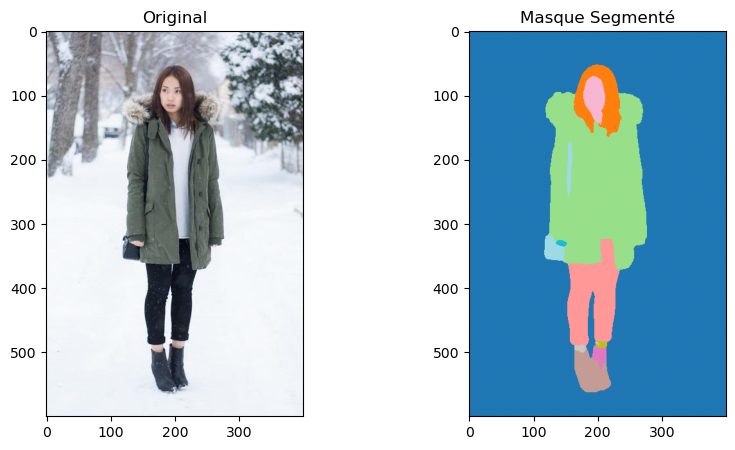

In [ ]:
# 4. Segmentation d'une Seule Image

if image_paths:
    single_image_path = image_paths[0]
    print(f"Traitement de l'image : {single_image_path}")

    try:
        # Lire l'image en binaire
        with open(single_image_path, "rb") as f:
            image_data = f.read()
        ext = os.path.splitext(single_image_path)[1].lower()
        headers["Content-Type"] = f"image/{ext[1:]}"
  

        # Appel API
        response = requests.post(API_URL, headers=headers, data=image_data)
        response.raise_for_status()


        results = response.json()
        
        # Traitement
        width, height = get_image_dimensions(single_image_path)
        final_mask = create_masks(results, width, height)
        
        # Affichage
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(Image.open(single_image_path))
        ax[0].set_title("Original")
        ax[1].imshow(final_mask, cmap='tab20')
        ax[1].set_title("Masque Segmenté")
        plt.show()

    except Exception as e:
        print(f"Une erreur est survenue : {e}")
        if 'response' in locals():
             print(f"Statut: {response.status_code}")
             print(f"Contenu réponse : {response.content[:300]}...")

In [ ]:
# 5. Segmentation de Plusieurs Images (Batch)

def segment_images_batch(list_of_image_paths):
    batch_segmentations = []
    
    for img_path in tqdm(list_of_image_paths, desc="Segmentation en cours"):
        try:
            with open(img_path, "rb") as f:
                data = f.read()
            
            response = requests.post(API_URL, headers=headers, data=data)
            if response.status_code == 200:
                results = response.json()
                width, height = get_image_dimensions(img_path)
                mask = create_masks(results, width, height)
                batch_segmentations.append(mask)
                
                # Sauvegarde immédiate du résultat (requis pour le projet)
                filename = os.path.basename(img_path)
                Image.fromarray(mask).save(os.path.join(results_dir, f"seg_{filename}"))
            else:
                print(f"Erreur API sur {img_path}: {response.status_code}")
                batch_segmentations.append(None)
        except Exception as e:
            print(f"Exception sur {img_path}: {e}")
            batch_segmentations.append(None)
            
    return batch_segmentations

# Exécution sur toutes les images
if image_paths:
    print(f"\nTraitement de {len(image_paths)} image(s) en batch...")
    batch_seg_results = segment_images_batch(image_paths)
    print("Traitement en batch terminé.")


Traitement de 50 image(s) en batch...


Segmentation en cours:   0%|          | 0/50 [00:00<?, ?it/s]

Traitement en batch terminé.


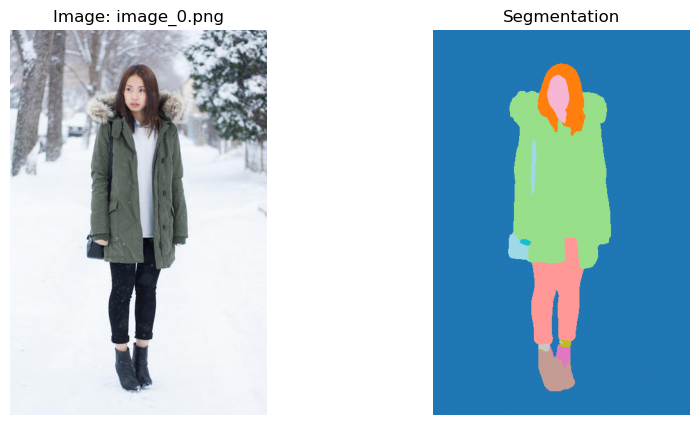

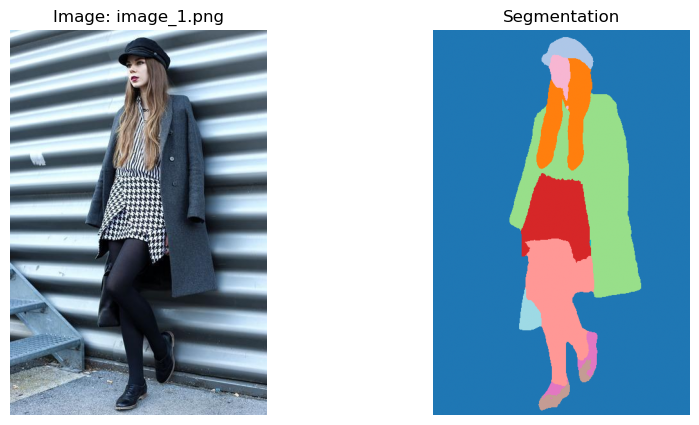

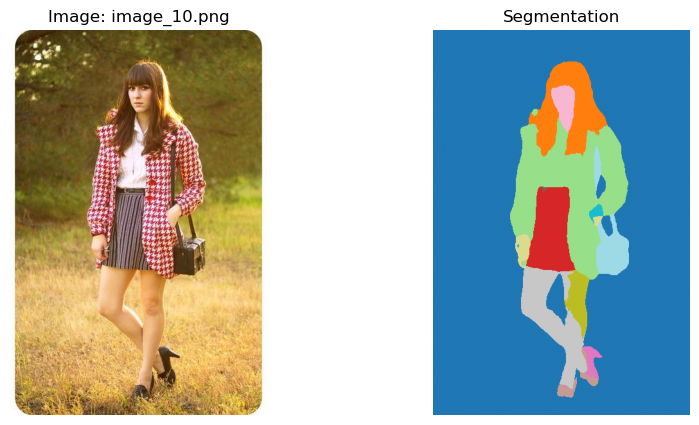

In [ ]:
# 6. Affichage des Résultats

def display_segmented_images_batch(original_image_paths, segmentation_masks, limit=3):
    count = 0
    for img_path, mask in zip(original_image_paths, segmentation_masks):
        if mask is not None and count < limit:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(Image.open(img_path))
            ax[0].set_title(f"Image: {os.path.basename(img_path)}")
            ax[0].axis('off')
            
            ax[1].imshow(mask, cmap='tab20')
            ax[1].set_title("Segmentation")
            ax[1].axis('off')
            plt.show()
            count += 1

display_segmented_images_batch(image_paths, batch_seg_results)

## 7. Rapport Synthétique et Coûts (Brief Projet)

### Validation (IoU)
Nous calculons ici la performance sur les images ayant un masque de vérité terrain correspondant.


In [ ]:
iou_scores = []

def calculate_iou(pred_mask, gt_mask_path):
    gt_mask = Image.open(gt_mask_path).convert("L")
    # Redimensionnement du GT si nécessaire
    gt_array = np.array(gt_mask.resize(pred_mask.shape[::-1], Image.NEAREST))
    
    # Binarisation simple pour l'IoU global (Vêtement vs Fond)
    pred_bool = pred_mask > 0
    gt_bool = gt_array > 0
    
    intersection = np.logical_and(pred_bool, gt_bool).sum()
    union = np.logical_or(pred_bool, gt_bool).sum()
    
    return intersection / union if union > 0 else 0.0

for img_path, pred_mask in zip(image_paths, batch_seg_results):
    if pred_mask is not None:
        filename = os.path.basename(img_path)
        mask_filename = filename.replace("image", "mask")
        gt_path = os.path.join(mask_dir, mask_filename)
        
        if os.path.exists(gt_path):
            score = calculate_iou(pred_mask, gt_path)
            iou_scores.append(score)

if iou_scores:
    print(f"IoU Moyen sur {len(iou_scores)} images : {np.mean(iou_scores):.2%}")
else:
    print("Pas de masques de vérité terrain trouvés pour le calcul IoU.")

IoU Moyen sur 50 images : 94.64%


### Estimation des Coûts
Pour 500 000 images par mois sur une infrastructure dédiée Hugging Face (A10G Small):
- Temps estimé : ~69.4 heures
- Coût estimé : **~105$ / mois**